In [122]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [123]:
df = pd.read_csv('rollingsales_bronx.xls_prepped_bare.csv')

In [124]:
df.reset_index(drop=True)

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
0,1,10457,600000,2021-01-15
1,1,10457,475000,2020-07-23
2,1,10457,289000,2020-08-25
3,1,10457,526000,2020-09-22
4,1,10457,734000,2020-04-22
...,...,...,...,...
3977,2,10470,290809,2021-03-04
3978,2,10470,129000,2020-08-31
3979,2,10470,210000,2021-01-23
3980,2,10470,305803,2020-12-18


In [125]:
df['SALE DATE']= pd.to_datetime(df['SALE DATE'])
df=df.sort_values(by='SALE DATE')

In [126]:
type(df['SALE DATE'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [127]:
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])

In [128]:
df_price_date = df_price_date.set_index('SALE DATE')

In [129]:
# df_price_date.index.unique

In [130]:
#group by day
df_price_date = df_price_date.resample('D').mean()

In [131]:
df_price_date['SALE PRICE']=df_price_date['SALE PRICE'].fillna(0)

In [132]:
df_price_date.dropna(inplace=True)

In [133]:
df_price_date.loc[(df_price_date!=0).any(1)]

,SALE PRICE
SALE DATE,
2020-04-01,1.234333e+06
2020-04-02,5.502250e+05
2020-04-03,6.185000e+05
2020-04-06,5.919458e+05
2020-04-07,3.577680e+05
...,...
2021-03-25,5.115159e+05
2021-03-26,1.018866e+06
2021-03-29,4.119000e+05


In [134]:
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [135]:
register_matplotlib_converters()

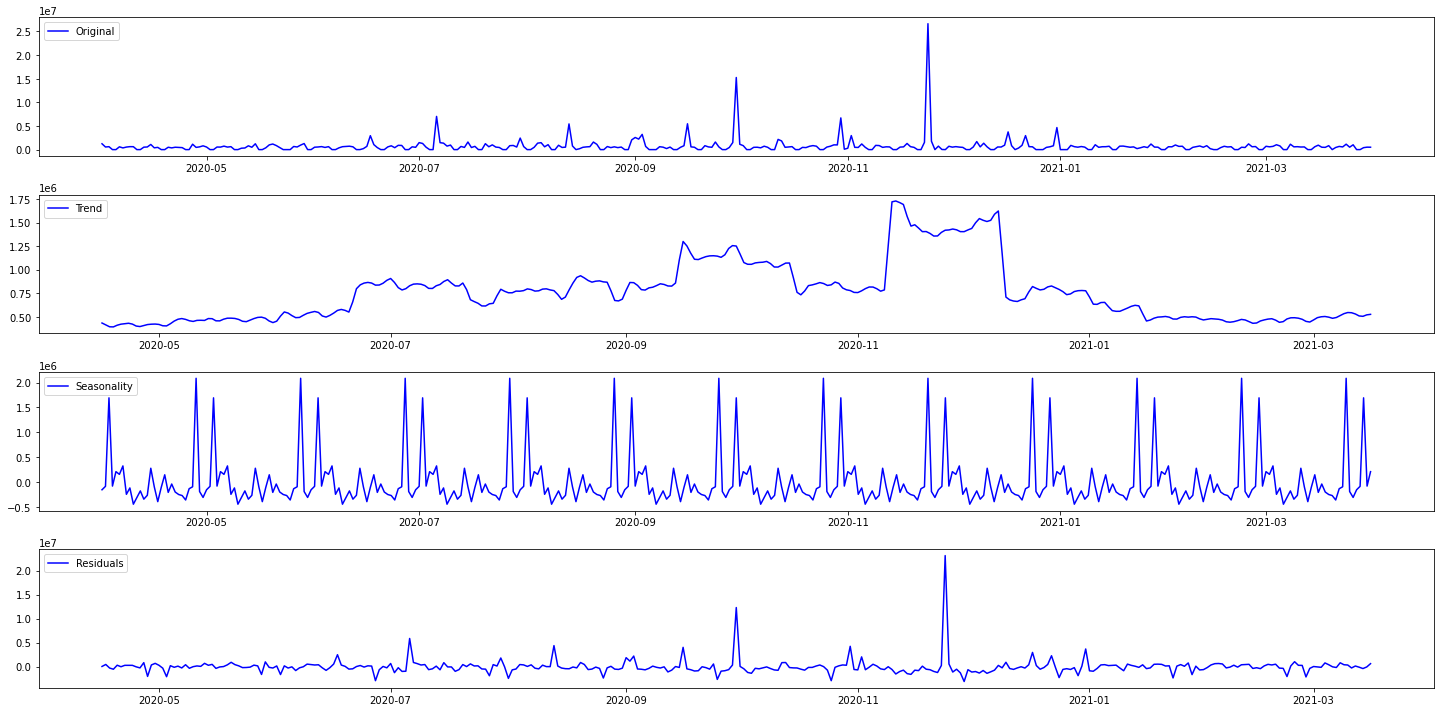

In [136]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [137]:
# df_price_date['roll_avg'] = df_price_date['SALE PRICE'].rolling(window=5).mean()

In [138]:
# df_price_date

In [139]:
# plt.figure(figsize=(20, 10))
# plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
# plt.scatter(df_price_date.index[4:365], df_price_date['roll_avg'][4:365], s=20);

In [140]:
# lr = LinearRegression()
# lr.fit(df_price_date[['roll_avg']][4:], df_price_date['SALE PRICE'][4:])

In [141]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_price_date.index[:265], df_price_date['SALE PRICE'][:265], label='Data')
# plt.plot(df_price_date.index[4:265], lr.predict(df_price_date[['roll_avg']][4:265]),
#          label='Predicted')
# plt.legend();

In [142]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-17.412873087453534, 4.874614202176964e-30, 0, 364, {'1%': -3.4484434475193777, '5%': -2.869513170510808, '10%': -2.571017574266393}, 10985.016277772373)

Test Statistic                -1.741287e+01
p-value                        4.874614e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


In [143]:
#differencing to remove seasonality period 12 rolling mean
df_price_date_diff= df_price_date.diff(periods=31)
df_price_date_diff.dropna(inplace=True)
df_price_date_diff.reset_index(drop=True)


,SALE PRICE
0,-1.234333e+06
1,-5.502250e+05
2,-7.418000e+04
3,5.298000e+05
4,7.339999e+05
...,...
329,-1.209026e+06
330,-6.080705e+05
331,-2.332125e+05
332,5.161438e+05


In [144]:
df_price_date = df_price_date - df_price_date_diff

In [145]:
df_price_date.dropna(inplace=True)

In [146]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-16.665262030533754, 1.561650123166583e-29, 0, 333, {'1%': -3.450141065277327, '5%': -2.870258846235788, '10%': -2.571415151457764}, 10032.16000793052)

Test Statistic                -1.666526e+01
p-value                        1.561650e-29
#Lags Used                     0.000000e+00
Number of Observations Used    3.330000e+02
Critical Value (1%)           -3.450141e+00
Critical Value (5%)           -2.870259e+00
Critical Value (10%)          -2.571415e+00
dtype: float64


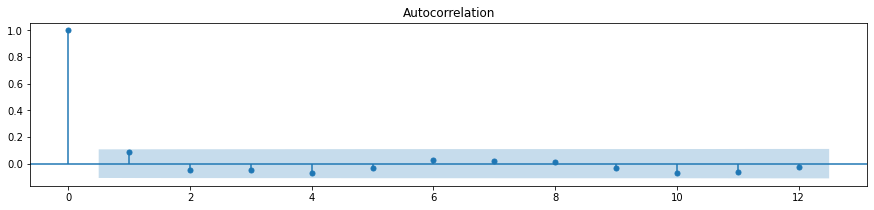

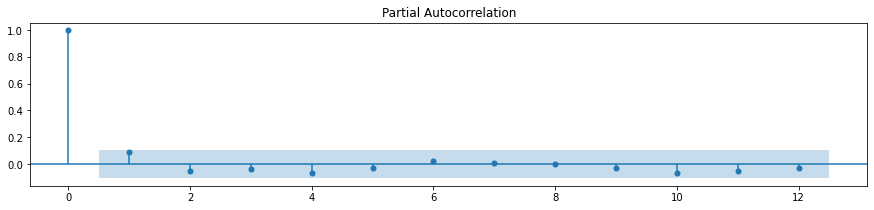

In [147]:
rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date, lags=12, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date, lags=12, alpha=0.05);

In [148]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
#about 2/3 of the way between 25 and 50, 2/3 of 25 is roughly 17. Ill say 25 + 17 = 42
p = 4

 # q = lagged forecast errors - PACF
    
q = 4


# Fitting ARMA model and summary
ar = ARMA(df_price_date,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  334
Model:                     ARMA(4, 4)   Log Likelihood               -5281.551
Method:                       css-mle   S.D. of innovations        1762617.123
Date:                Sat, 12 Jun 2021   AIC                          10583.103
Time:                        22:05:32   BIC                          10621.214
Sample:                    05-02-2020   HQIC                         10598.298
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             7.554e+05   9.79e+04      7.713      0.000    5.63e+05    9.47e+05
ar.L1.SALE PRICE     0.6895      0.021     32.613      0.000       0.648       0.731
ar.L2.SALE PRICE    -1.2788      0.024    -54.397      0.000      -1.325      -1.233
ar.L3.SALE PRICE     0.6571      0.018     36.835      0.000       0.622       0.692
ar.L4.SALE PRICE    -0.9738        nan        nan        nan         nan         nan
ma.L1.SALE PRICE    -0.6684      0.026    -26.162      0.000      -0.718      -0.618
ma.L2.SALE PRICE     1.2721      0.024     52.221      0.000       1.224       1.320
ma.L3.SALE PRICE    -0.6684      0.024    -28.114      0.000      -0.715      -0.622
ma.L4.SALE PRICE     1.0000      0.027     37.083      0.000       0.947       1.053
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6235           -0.7819j            1.0001           -0.1429
AR.2            0.6235           +0.7819j            1.0001            0.1429
AR.3           -0.2861           -0.9720j            1.0133           -0.2956
AR.4           -0.2861           +0.9720j            1.0133            0.2956
MA.1           -0.2911           -0.9567j            1.0000           -0.2970
MA.2           -0.2911           +0.9567j            1.0000            0.2970
MA.3            0.6252           -0.7804j            1.0000           -0.1425
MA.4            0.6252           +0.7804j            1.0000            0.1425
-----------------------------------------------------------------------------
"""

In [149]:
r2_score(df_price_date, ar.predict())

0.0698118579110778

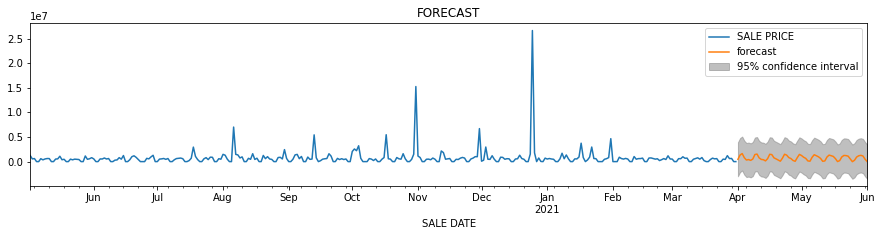

In [150]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date.plot(ax=ax, title='FORECAST')
fig = ar.plot_predict('2021-04-01', '2021-06-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()